## Deep Convolutional Generative Adversarial Networks
Another network architecture for learning to generate new content is the DCGAN. Like the VAE, our DCGAN consists of two parts:
* The _discriminator_ learns how to distinguish fake from real objects of the type we'd like to create
* The _generator_ creates new content and tries to fool the discriminator

There is a HackerNoon article by Chanchana Sornsoontorn that explains the concept in more detail and describes some creative projects DCGANs have been applied to. One of these projects is the generation of MNIST characters. Let's try to use python and tensorflow for the same purpose.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

c:\users\ashwin nayak\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Code by Parag Mital (github.com/pkmital/CADL)
def montage(images):
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    m = np.ones((images.shape[1] * n_plots + n_plots + 1, images.shape[2] * n_plots + n_plots + 1)) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    return m

## Setting up the basics
Like in the last tutorial, we use tensorflow's own method for accessing batches of MNIST characters. We set our batch size to be 64. Our generator will take noise as input. The number of these inputs is being set to 100. Batch normalization considerably improved the training of this network. For tensorflow to apply batch normalization, we need to let it know whether we are in training mode. The variable _keep_prob_ will be used by our dropout layers, which we introduce for more stable learning outcomes.
_lrelu_ defines the popular leaky ReLU, that hopefully will be supported by future versions of tensorflow! I firstly tried to apply standard ReLUs to this network, but this lead to the well-known _dying ReLU problem_, and I received generated images that looked like artwork by Kazimir Malevich--I just got black squares. 

Then, we define a function _binary_cross_entropy_, which we will use later, when computing losses.

In [6]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')
tf.reset_default_graph()
batch_size = 64
n_noise = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
noise = tf.placeholder(dtype=tf.float32, shape=[None, n_noise])

keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
is_training = tf.placeholder(dtype=tf.bool, name='is_training')

def lrelu(x):
    return tf.maximum(x, tf.multiply(x, 0.2))

def binary_cross_entropy(x, z):
    eps = 1e-12
    return (-(x * tf.log(z + eps) + (1. - x) * tf.log(1. - z + eps)))

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


## The discriminator
Now, we can define the discriminator. As input, it takes real or fake MNIST digits (28 x 28 pixel grayscale images) and applies a series of convolutions. Finally, we use a sigmoid to make sure our output can be interpreted as the probability to that the input image is a real MNIST character.

In [7]:
def discriminator(img_in, reuse=None, keep_prob=keep_prob):
    activation = lrelu
    with tf.variable_scope("discriminator", reuse=reuse):
        x = tf.reshape(img_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=128, activation=activation)
        x = tf.layers.dense(x, units=1, activation=tf.nn.sigmoid)
        return x

## The generator
The generator--just takes noise and tries to learn how to transform this noise into digits. To this end, it applies several transpose convolutions. At first, I didn't apply batch normalization to the generator, and its learning seemed to be really unefficient. After applying batch normalization layers, learning improved considerably. Also, I firstly had a much larger dense layer accepting the generator input. This led to the generator creating the same output always, no matter what the input noise was. Tuning the generator honestly took quite some effort!

In [8]:
def generator(z, keep_prob=keep_prob, is_training=is_training):
    activation = lrelu
    momentum = 0.99
    with tf.variable_scope("generator", reuse=None):
        x = z
        d1 = 4
        d2 = 1
        x = tf.layers.dense(x, units=d1 * d1 * d2, activation=activation)
        x = tf.layers.dropout(x, keep_prob)      
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)  
        x = tf.reshape(x, shape=[-1, d1, d1, d2])
        x = tf.image.resize_images(x, size=[7, 7])
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=1, strides=1, padding='same', activation=tf.nn.sigmoid)
        return x    

## Loss functions and optimizers
Now, we wire both parts together.
However, we have to create two objects of our discriminator
* The first object receives the real images
* The second object receives the fake images

_reuse_ of the second object is set to _True_ so both objects share their variables. We need both instances for computing two types of losses:
* when receiving real images, the discriminator should learn to compute high values (near _1_), meaning that it is confident the input images are real
* when receiving fake images, it should compute low values (near _0_), meaning it is confident the input images are not real

To accomplish this, we use the _binary cross entropy_ function defined earlier. The generator tries to achieve the opposite goal, it tries to make the discriminator assign high values to fake images.

Now, we also apply some regularization. We create two distinct optimizers, one for the discriminator, one for the generator. We have to define which variables we allow these optimizers to modify, otherwise the generator's optimizer could just mess up the discriminator's variables and vice-versa.

We have to provide the __update_ops__ to our optimizers when applying batch normalization--take a look at the tensorflow documentation for more information on this topic.

In [9]:
g = generator(noise, keep_prob, is_training)
d_real = discriminator(X_in)
d_fake = discriminator(g, reuse=True)

vars_g = [var for var in tf.trainable_variables() if var.name.startswith("generator")]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]


d_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_d)
g_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_g)

loss_d_real = binary_cross_entropy(tf.ones_like(d_real), d_real)
loss_d_fake = binary_cross_entropy(tf.zeros_like(d_fake), d_fake)
loss_g = tf.reduce_mean(binary_cross_entropy(tf.ones_like(d_fake), d_fake))
loss_d = tf.reduce_mean(0.5 * (loss_d_real + loss_d_fake))

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_d + d_reg, var_list=vars_d)
    optimizer_g = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_g + g_reg, var_list=vars_g)
    
    
sess = tf.Session()
sess.run(tf.global_variables_initializer())

## Training the DCGAN
Finally, the fun part begins--let's train our network! 
We feed random values to our generator, which will learn to create digits out of this noise. We also take care that neither the generator nor the discriminator becomes too strong--otherwise, this would inhibit the learning of the other part and could even stop the network from learning anything at all (I unfortunately have made this experience).

0 0.640432 1.397536 0.98369706 0.2971669
not training discriminator


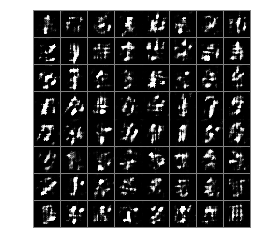

50 0.5329347 1.0808991 0.6100869 0.4557826
not training discriminator


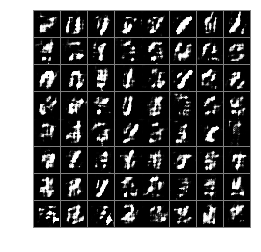

100 0.82826054 1.7365849 1.4571757 0.19934541
not training discriminator


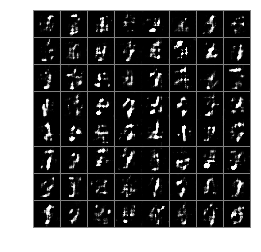

150 0.5524707 1.1192572 0.6839113 0.42102998
not training discriminator


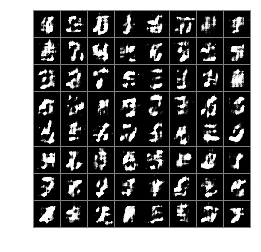

200 0.6231307 1.4320221 0.95232534 0.29393604
not training discriminator


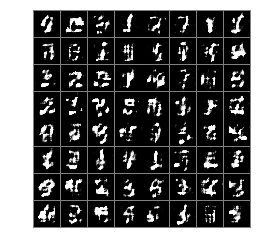

250 0.58290315 1.4844165 0.89577115 0.27003527
not training discriminator


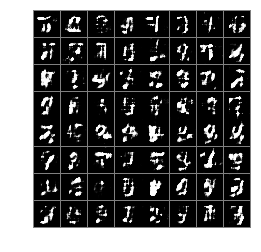

300 0.61926764 0.55561966 0.29652894 0.94200647


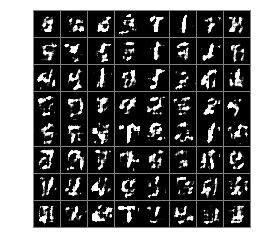

350 0.4641894 0.9624901 0.41108742 0.5172914
not training discriminator


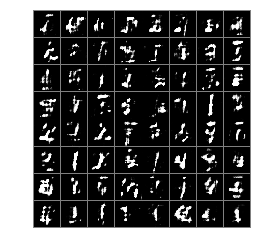

400 0.7293948 1.4604082 1.184525 0.2742645
not training discriminator


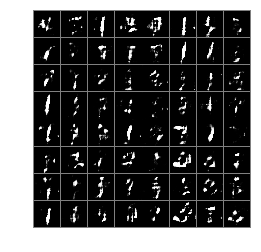

450 0.5422817 1.1500487 0.64417166 0.44039175
not training discriminator


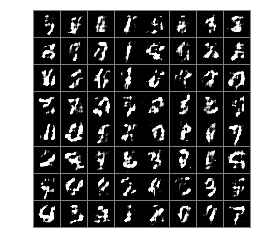

500 0.5433401 1.2780783 0.7088796 0.37780058
not training discriminator


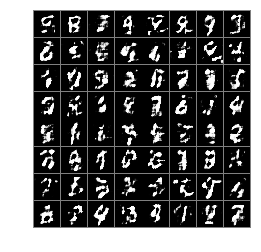

550 0.5926968 1.3362784 0.8440824 0.34131116
not training discriminator


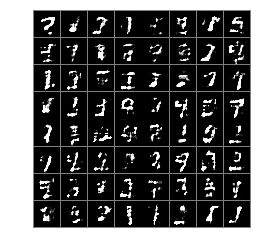

600 0.53938204 1.2230306 0.6915926 0.3871715
not training discriminator


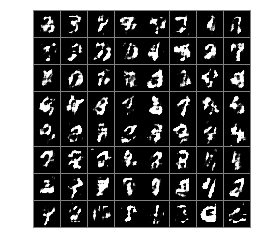

650 0.6004495 1.3428665 0.85539174 0.3455072
not training discriminator


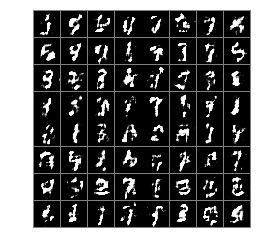

700 0.65950376 1.5801845 1.0570837 0.26192382
not training discriminator


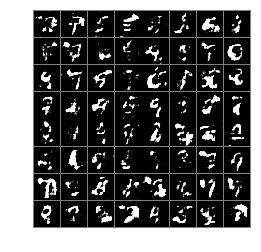

750 0.61262786 1.5447085 0.9633016 0.2619542
not training discriminator


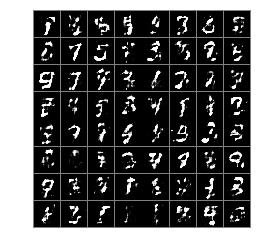

800 0.623846 1.1384325 0.7982758 0.4494161


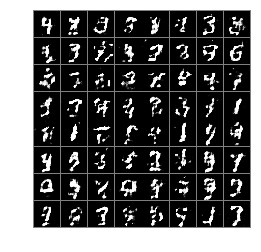

850 0.575548 1.437876 0.8246209 0.32647505
not training discriminator


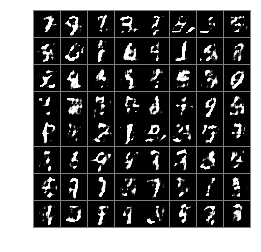

900 0.67790574 1.298562 1.0091598 0.3466516


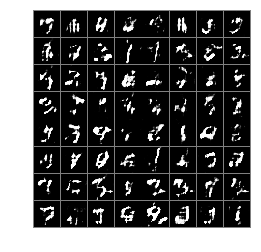

950 0.53348076 1.2733555 0.70555204 0.36140952
not training discriminator


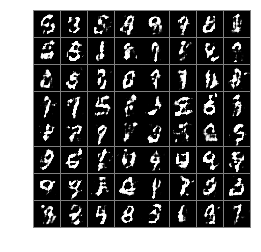

1000 0.6124147 1.3196955 0.87448 0.35034937
not training discriminator


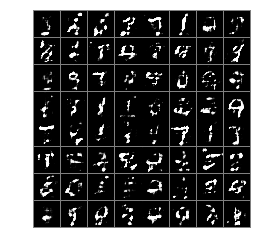

1050 0.5612713 1.3295228 0.75852907 0.3640136
not training discriminator


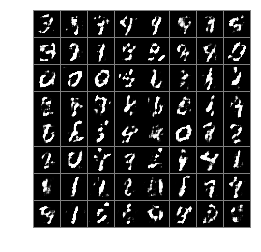

1100 0.71956795 1.4777251 1.1080372 0.33109862
not training discriminator


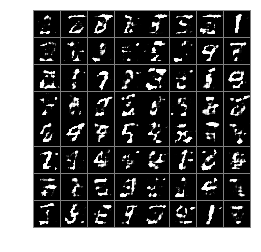

1150 0.53638715 1.4162922 0.7557432 0.31703115
not training discriminator


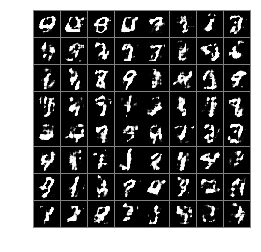

1200 0.49991578 1.0464275 0.4743868 0.52544475
not training discriminator


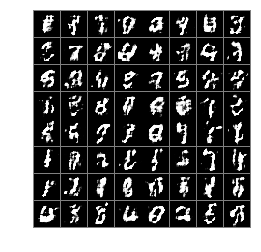

1250 0.5547014 1.3285764 0.7655132 0.34388956
not training discriminator


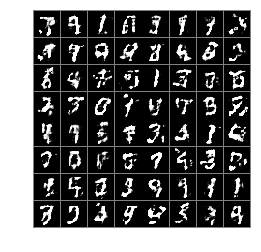

1300 0.67585814 1.6203063 1.0885267 0.26318967
not training discriminator


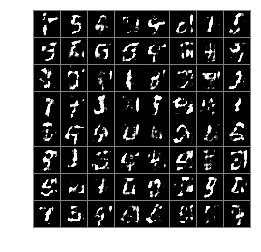

1350 0.4987887 1.1079161 0.5310992 0.4664782
not training discriminator


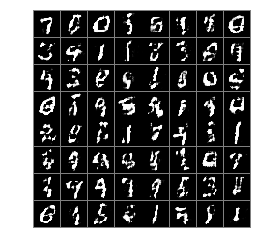

1400 0.625159 1.5725287 0.9761534 0.2741647
not training discriminator


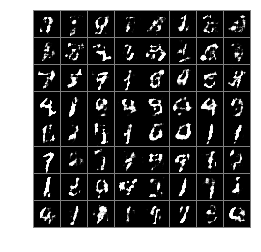

1450 0.56680334 1.461947 0.8366673 0.29693943
not training discriminator


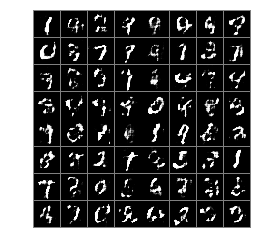

1500 0.52888685 1.3982755 0.7230845 0.3346892
not training discriminator


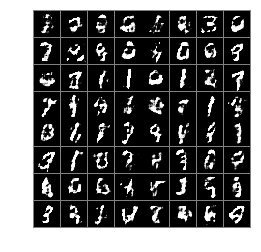

1550 0.45892835 0.9923128 0.37205207 0.5458045
not training discriminator


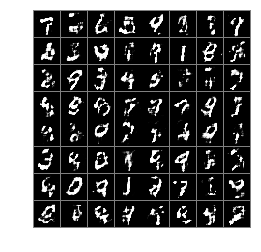

1600 0.56600046 1.450324 0.83899146 0.29300952
not training discriminator


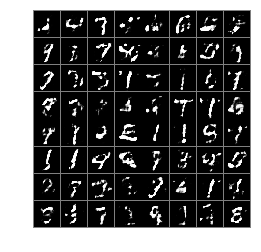

1650 0.531086 1.2112887 0.67421687 0.38795525
not training discriminator


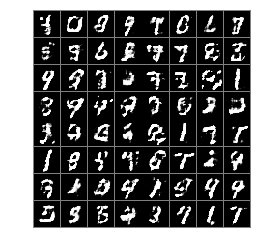

1700 0.5969722 1.4556726 0.87241924 0.32152537
not training discriminator


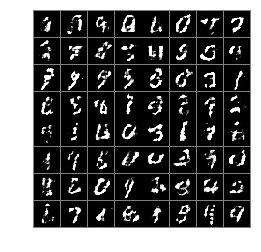

1750 0.6278703 1.2527153 0.8544416 0.40129918


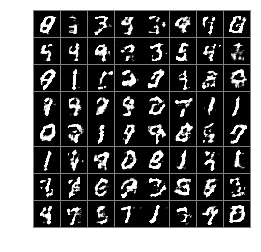

1800 0.59013325 1.3826609 0.8591348 0.3211317
not training discriminator


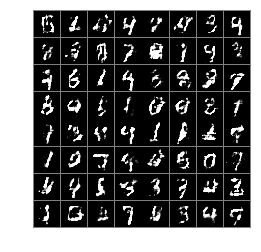

1850 0.547912 1.3742654 0.7728426 0.32298142
not training discriminator


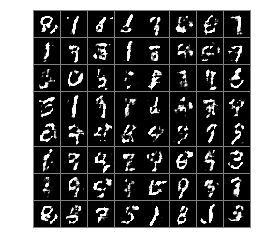

1900 0.6290912 1.2167156 0.8509044 0.40727803


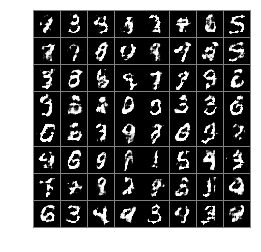

1950 0.5195453 1.0862265 0.55440766 0.48468292
not training discriminator


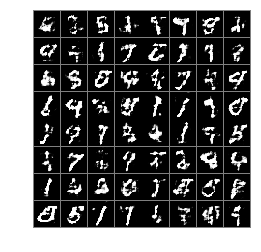

2000 0.5649984 1.6417141 0.8930204 0.23697643
not training discriminator


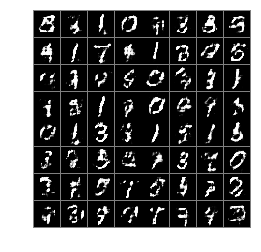

2050 0.67907983 1.414084 1.05772 0.3004398
not training discriminator


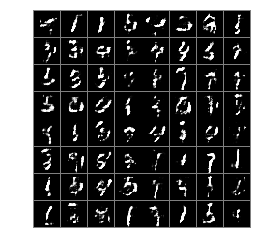

2100 0.51999974 1.2056594 0.62635225 0.41364723
not training discriminator


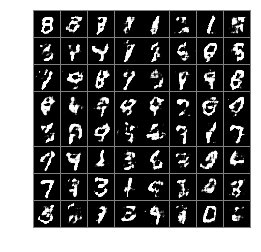

2150 0.70011055 1.7099228 1.177844 0.2223771
not training discriminator


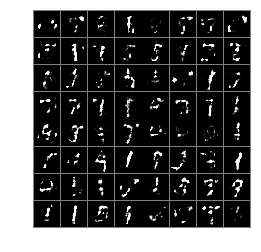

2200 0.5898839 1.1526022 0.76375026 0.41601753


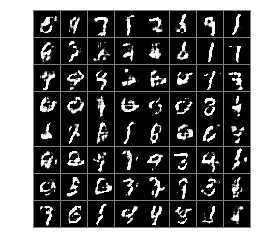

2250 0.5613218 1.2078294 0.7222309 0.40041268
not training discriminator


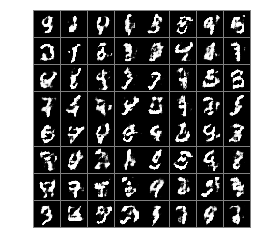

2300 0.607423 1.3134989 0.8736069 0.34123898
not training discriminator


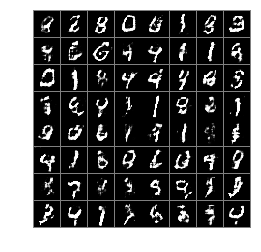

2350 0.57520163 1.3141887 0.8077787 0.3426246
not training discriminator


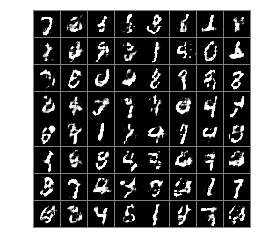

2400 0.51224786 1.3108783 0.6582794 0.36621618
not training discriminator


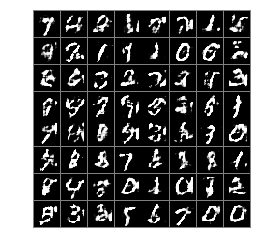

2450 0.45268154 0.9709247 0.36650044 0.5388626
not training discriminator


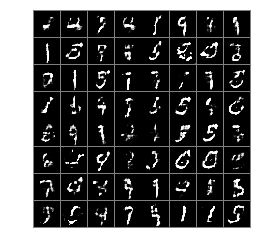

2500 0.5411943 1.5992738 0.82115364 0.26123494
not training discriminator


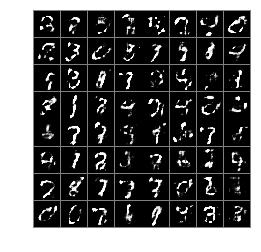

2550 0.58349967 1.51078 0.8874427 0.27955663
not training discriminator


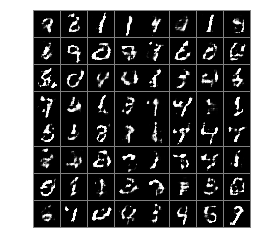

2600 0.55516815 1.1435959 0.6763722 0.4339641
not training discriminator


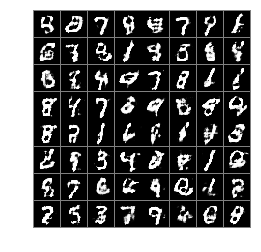

2650 0.55937713 1.1625917 0.68944156 0.4293127
not training discriminator


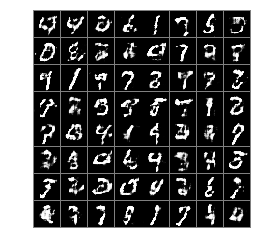

2700 0.52728975 1.206557 0.6729429 0.38163668
not training discriminator


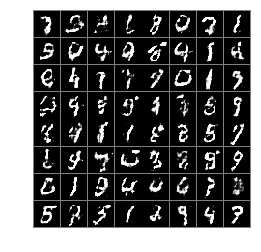

2750 0.5173551 0.85685587 0.4042273 0.6304829


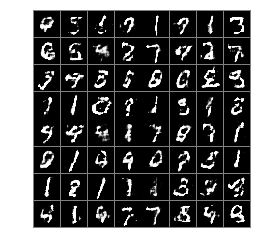

2800 0.66114056 1.5302186 1.0123551 0.309926
not training discriminator


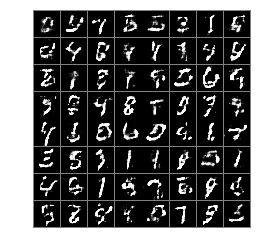

2850 0.51062596 1.4000026 0.67410415 0.34714785
not training discriminator


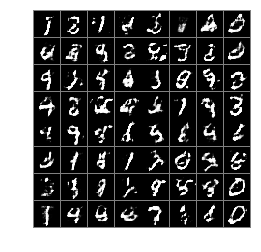

In [ ]:
for i in range(10000):
    train_d = True
    train_g = True
    keep_prob_train = 0.6 # 0.5
    
    
    n = np.random.uniform(0.0, 1.0, [batch_size, n_noise]).astype(np.float32)   
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]  
    
    d_real_ls, d_fake_ls, g_ls, d_ls = sess.run([loss_d_real, loss_d_fake, loss_g, loss_d], feed_dict={X_in: batch, noise: n, keep_prob: keep_prob_train, is_training:True})
    
    d_real_ls = np.mean(d_real_ls)
    d_fake_ls = np.mean(d_fake_ls)
    g_ls = g_ls
    d_ls = d_ls
    
    if g_ls * 1.5 < d_ls:
        train_g = False
        pass
    if d_ls * 2 < g_ls:
        train_d = False
        pass
    
    if train_d:
        sess.run(optimizer_d, feed_dict={noise: n, X_in: batch, keep_prob: keep_prob_train, is_training:True})
        
        
    if train_g:
        sess.run(optimizer_g, feed_dict={noise: n, keep_prob: keep_prob_train, is_training:True})
        
        
    if not i % 50:
        print (i, d_ls, g_ls, d_real_ls, d_fake_ls)
        if not train_g:
            print("not training generator")
        if not train_d:
            print("not training discriminator")
        gen_img = sess.run(g, feed_dict = {noise: n, keep_prob: 1.0, is_training:False})
        imgs = [img[:,:,0] for img in gen_img]
        m = montage(imgs)
        gen_img = m
        plt.axis('off')
        plt.imshow(gen_img, cmap='gray')
        plt.show()